In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

Inizializzo le variabili di interesse e definisco il parametro rho_m.

In [2]:
rho_m = 0.286 * 0.7**2 *2.7751428946e11
M = np.array([10**13.5, 10**14.0, 10**15.0])
c = np.array([2, 5, 10])
z = 0.
R = np.linspace(0.03,1.0,1000)
rho_m

38890852524.924385

Calcolo r_s sotto forma di matrice 3x3. Ogni entrata contiene il prodotto tra un diverso elemento di 1/c e del termine in radice cubica.

Nota: Le entrate della matrice sono:
    np.outer(a,b) = 
    ([[a1b1, a1b2, a1b3],
      [a2b1, a2b2, a2b3],
      [a3b1, a3b2, a3b3]])

In [3]:
r_s = np.outer(np.cbrt(3 * M / (4 * np.pi * 200 * rho_m * (1+z)**3)), 1/c)
r_s

array([[0.49504877, 0.19801951, 0.09900975],
       [0.72663221, 0.29065289, 0.14532644],
       [1.56548165, 0.62619266, 0.31309633]])

Calcolo rho_s.

In [4]:
f_c = np.log(1 + c) - c / (1 + c)
delta_char = 200 * c**3 / (3 * f_c)
rho_s = rho_m * (1+z)**3 * delta_char
rho_s

array([4.80194426e+13, 3.38148581e+14, 1.74148032e+15])

Infine calcolo f(x). x sarà un array 1000x3x3 in cui ogni entrata è funzione di un diverso valore di R,c ed M. Allo stesso modo f sarà una matrice delle stesse dimensioni in cui ogni entrata è la funzione f applicata alla corrispondente entrata di x.

In [5]:
x = np.multiply.outer(R, 1/r_s)
ones = np.ones((1000, 3, 3))

In [6]:
f = np.empty((1000, 3, 3))
for i in range(1000):
    for j in range(3):
        for k in range(3):
            if np.less(x, ones)[i, j, k]:
                f[i, j, k] = (1 - (2 * np.arctanh(np.sqrt((1-x[i, j, k])/(1+x[i, j, k]))) / np.sqrt(1 - x[i, j, k]**2))) / (x[i, j, k]**2 - 1)
            else: 
                if np.greater(x, ones)[i, j, k]:
                    f[i, j, k] = (1 - (2 * np.arctan(np.sqrt((x[i, j, k]-1)/(1+x[i, j, k]))) / np.sqrt(x[i, j, k]**2 - 1))) / (x[i, j, k]**2 - 1)
                else: 
                    f[i, j, k] = 1./3

Il risultato ottenuto è corretto, ma è poco efficiente questa implementazione, perché opera elemento per elemento su 9000 elementi diversi con 3 for innestati uno nell'altro. Posso piuttosto osservare che le funzioni che definiscono f negli intervalli x<1 e x>1 hanno domini disgiunti e utilizzare questo fatto a mio vantaggio.

In [7]:
f1 = (1 - (2 * np.arctanh(np.sqrt((1-x)/(1+x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
f2 = (1 - (2 * np.arctan(np.sqrt((x-1)/(1+x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
f1[np.isnan(f1)] = 0
f2[np.isnan(f2)] = 0
f = f1 + f2
f = np.where(f == 0., 1./3, f)
f

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_3084\1803051913.py:1: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1-x)/(1+x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_3084\1803051913.py:2: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x-1)/(1+x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)


array([[[2.51134577, 1.64228572, 1.05187222],
        [2.88817796, 1.99859943, 1.36815931],
        [3.65000087, 2.74161541, 2.06918868]],

       [[2.48027929, 1.61343523, 1.0270845 ],
        [2.85675277, 1.96850024, 1.34079687],
        [3.61826755, 2.71030554, 2.03890923]],

       [[2.45020997, 1.58560069, 1.00330256],
        [2.82631925, 1.93940911, 1.31445248],
        [3.58752024, 2.67998921, 2.00963616]],

       ...,

       [[0.1302552 , 0.02960447, 0.00848095],
        [0.22312385, 0.05669221, 0.01711937],
        [0.54876325, 0.1823138 , 0.0640137 ]],

       [[0.13006865, 0.02955446, 0.00846565],
        [0.22283572, 0.05660168, 0.01708944],
        [0.54822139, 0.1820681 , 0.06391279]],

       [[0.1298825 , 0.02950457, 0.00845038],
        [0.22254816, 0.05651137, 0.01705959],
        [0.54768038, 0.1818229 , 0.06381212]]])

In conclusione posso calcolare Sigma. Sarà una matrice 1000x3x3 in cui il primo indice scorre sugli R, il secondo scorre sugli M e il terzo scorre sui c.

In [8]:
Sigma = 2* rho_s * r_s * f
Sigma

array([[[1.19399251e+14, 2.19934952e+14, 3.62735057e+14],
        [2.01551349e+14, 3.92860137e+14, 6.92516110e+14],
        [5.48767092e+14, 1.16105307e+15, 2.25645480e+15]],

       [[1.17922229e+14, 2.16071294e+14, 3.54187085e+14],
        [1.99358343e+14, 3.86943608e+14, 6.78666167e+14],
        [5.43996079e+14, 1.14779358e+15, 2.22343499e+15]],

       [[1.16492615e+14, 2.12343692e+14, 3.45985949e+14],
        [1.97234542e+14, 3.81225231e+14, 6.65331526e+14],
        [5.39373310e+14, 1.13495485e+15, 2.19151264e+15]],

       ...,

       [[6.19284436e+12, 3.96463165e+12, 2.92463244e+12],
        [1.55706862e+13, 1.11438591e+13, 8.66525025e+12],
        [8.25049708e+13, 7.72084946e+13, 6.98070856e+13]],

       [[6.18397483e+12, 3.95793368e+12, 2.91935338e+12],
        [1.55505792e+13, 1.11260634e+13, 8.65009877e+12],
        [8.24235030e+13, 7.71044412e+13, 6.96970413e+13]],

       [[6.17512452e+12, 3.95125271e+12, 2.91408860e+12],
        [1.55305118e+13, 1.11083104e+13, 8.634987

Ho calcolato tutti i valori di Sigma di mio interesse e procedo a graficarli.

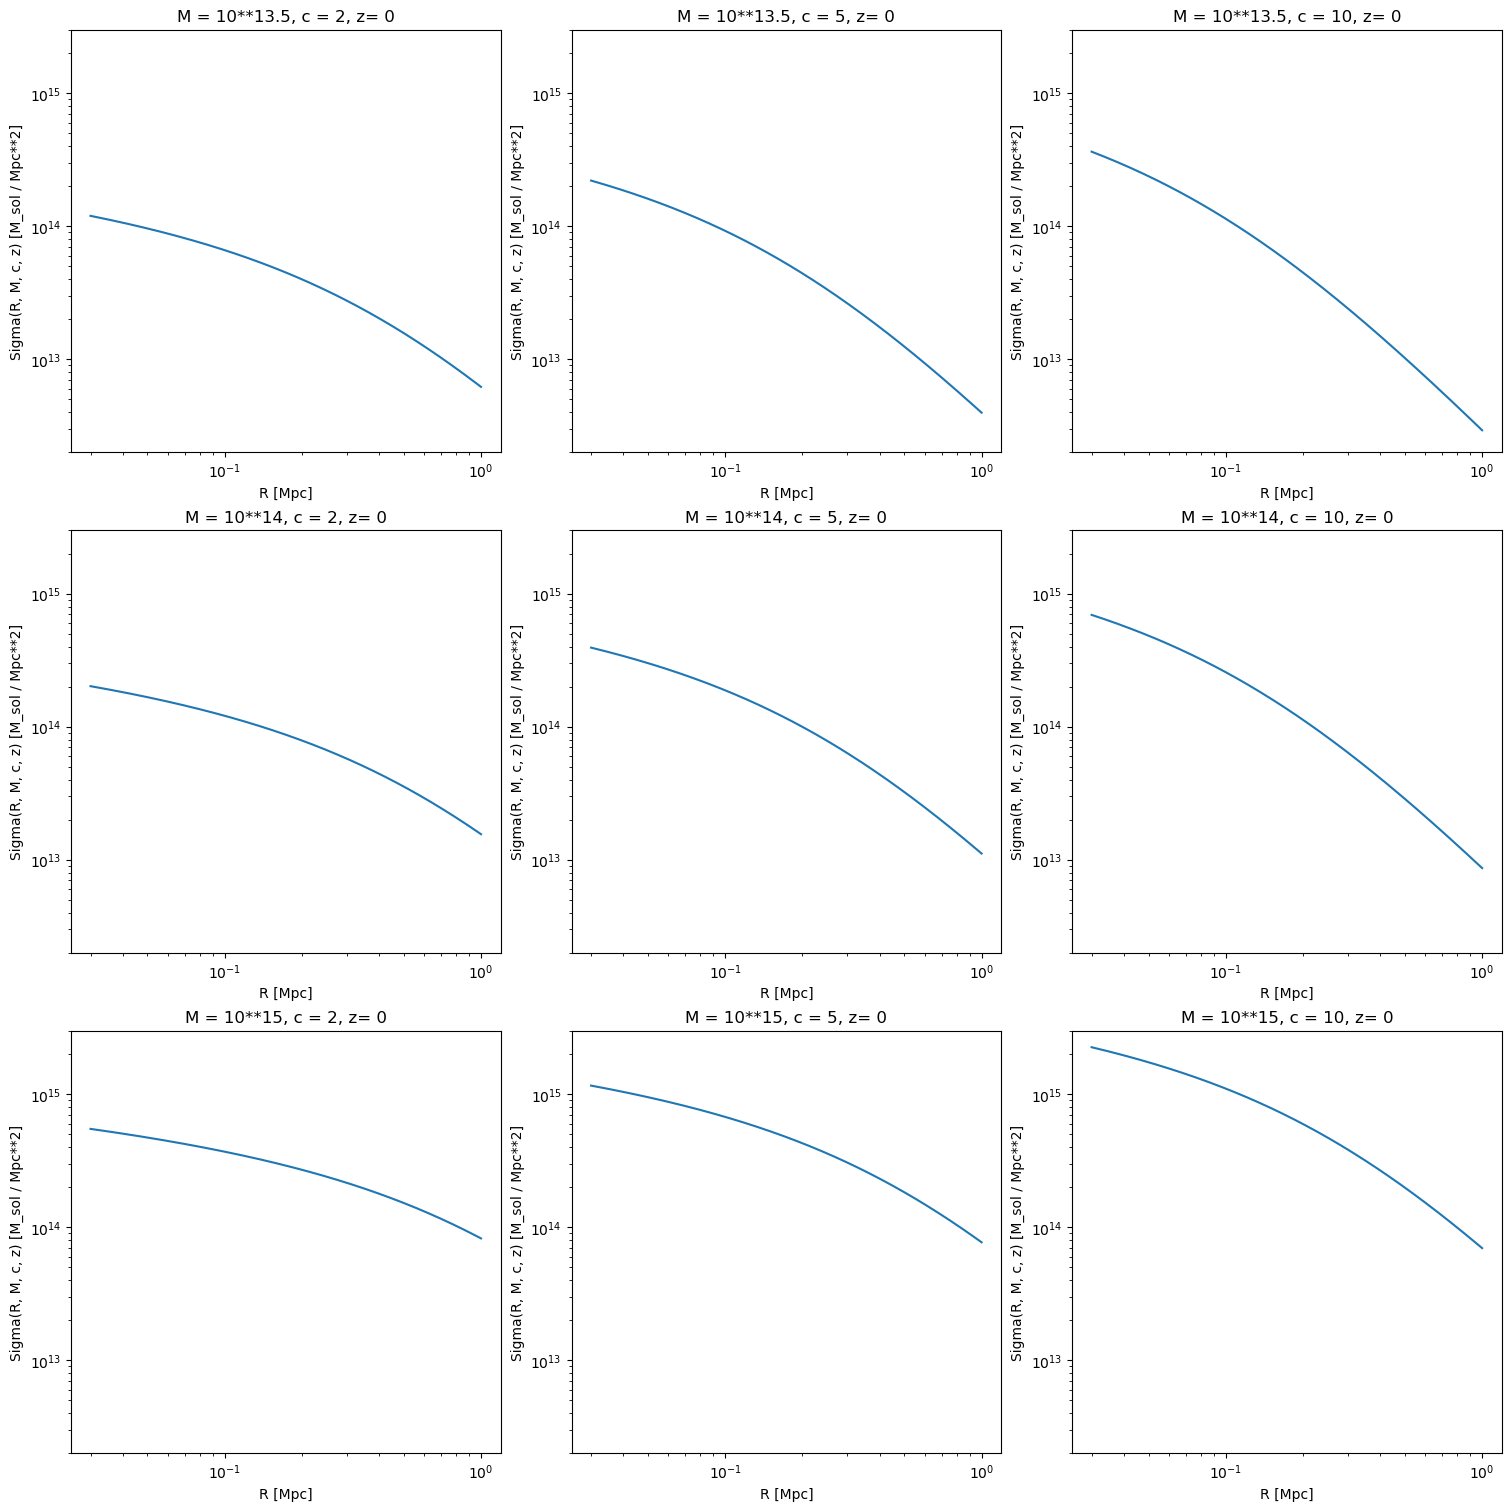

In [9]:
fig, axs = plt.subplots(3, 3, layout = 'constrained')
fig.set_size_inches(15, 15)

axs[0, 0].plot(R, Sigma[:, 0, 0])
axs[0, 0].set_title('M = 10**13.5, c = 2, z= 0')
axs[0, 1].plot(R, Sigma[:, 0, 1])
axs[0, 1].set_title('M = 10**13.5, c = 5, z= 0')
axs[0, 2].plot(R, Sigma[:, 0, 2])
axs[0, 2].set_title('M = 10**13.5, c = 10, z= 0')
axs[1, 0].plot(R, Sigma[:, 1, 0])
axs[1, 0].set_title('M = 10**14, c = 2, z= 0')
axs[1, 1].plot(R, Sigma[:, 1, 1])
axs[1, 1].set_title('M = 10**14, c = 5, z= 0')
axs[1, 2].plot(R, Sigma[:, 1, 2])
axs[1, 2].set_title('M = 10**14, c = 10, z= 0')
axs[2, 0].plot(R, Sigma[:, 2, 0])
axs[2, 0].set_title('M = 10**15, c = 2, z= 0')
axs[2, 1].plot(R, Sigma[:, 2, 1])
axs[2, 1].set_title('M = 10**15, c = 5, z= 0')
axs[2, 2].plot(R, Sigma[:, 2, 2])
axs[2, 2].set_title('M = 10**15, c = 10, z= 0')



for ax in axs.flat:
    ax.set(xlabel = 'R [Mpc]', ylabel = 'Sigma(R, M, c, z) [M_sol / Mpc**2]', xscale = 'log', yscale = 'log', ylim = [2e12, 3e15])

Importo i file con i dati

In [10]:
hdul = fits.open('halo_catalog.fits')
hdul.info()

Filename: halo_catalog.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   40103R x 3C   [E, E, 8E]   


Ho trovato che ci sono 2 HDU: Primary e una tabella. La tabella contiene i miei dati, perciò procedo a leggere quella.

In [11]:
data = hdul[1].data
data

FITS_rec([(0.5024944 , 290.69226 , [2.35110187e+15, 1.99265303e+15, 1.49606757e+15, 1.18663491e+15, 8.96338200e+14, 6.25385692e+14, 3.94313263e+14, 2.28581414e+14]),
          (0.6013021 , 119.24578 , [2.10765923e+15, 1.98006381e+15, 1.65222587e+15, 1.22958646e+15, 9.86441849e+14, 7.12462798e+14, 4.49373637e+14, 2.62464394e+14]),
          (0.20896086, 126.37386 , [1.81413701e+15, 1.73958698e+15, 1.34463924e+15, 1.12188935e+15, 8.70322039e+14, 5.94193290e+14, 3.66820205e+14, 1.86497462e+14]),
          ...,
          (0.62278223,   8.831167, [6.41927624e+14, 4.42689795e+14, 3.83484309e+14, 2.78102488e+14, 1.81649199e+14, 1.09778534e+14, 7.18503737e+13, 5.32619272e+13]),
          (0.5350497 ,  12.180819, [3.16326053e+14, 3.31781459e+14, 2.49146104e+14, 1.71900714e+14, 1.45082435e+14, 1.28306419e+14, 8.72312723e+13, 5.76063915e+13]),
          (0.49350488,  17.996544, [6.87486087e+14, 4.99000340e+14, 3.65499804e+14, 2.43635778e+14, 1.55504676e+14, 9.16257453e+13, 5.05067728e+13, 3.65255

In [12]:
data.columns.names

['Z', 'LAMBDA_TR', 'SIGMA_of_R']

In [13]:
SigR = data['SIGMA_of_R'] #questo è un numpyarray
np.shape(SigR)

(40103, 8)

In [14]:
data_dict = {'Z': data['Z'], 'LAMBDA_TR': data['LAMBDA_TR']}
df1 = pd.DataFrame(data_dict)
df1

,Z,LAMBDA_TR
0,0.502494,290.692261
1,0.601302,119.245781
2,0.208961,126.373863
3,0.212769,188.812729
4,0.458008,147.349625
...,...,...
40098,0.479437,9.510518
40099,0.599918,17.036392
40100,0.622782,8.831167
40101,0.535050,12.180819


In [15]:
df2 = pd.DataFrame(SigR, columns = ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4', 'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7'])
df2

,SIGMA_of_R0,SIGMA_of_R1,SIGMA_of_R2,SIGMA_of_R3,SIGMA_of_R4,SIGMA_of_R5,SIGMA_of_R6,SIGMA_of_R7
0,2.351102e+15,1.992653e+15,1.496068e+15,1.186635e+15,8.963382e+14,6.253857e+14,3.943133e+14,2.285814e+14
1,2.107659e+15,1.980064e+15,1.652226e+15,1.229586e+15,9.864418e+14,7.124628e+14,4.493736e+14,2.624644e+14
2,1.814137e+15,1.739587e+15,1.344639e+15,1.121889e+15,8.703220e+14,5.941933e+14,3.668202e+14,1.864975e+14
3,2.349731e+15,1.945845e+15,1.539410e+15,1.077038e+15,7.059310e+14,4.613497e+14,2.969404e+14,1.913648e+14
4,2.240655e+15,1.679705e+15,1.314239e+15,1.120241e+15,8.280310e+14,5.703857e+14,3.796933e+14,2.315893e+14
...,...,...,...,...,...,...,...,...
40098,7.317734e+14,7.352522e+14,5.704476e+14,3.042415e+14,1.612240e+14,9.388085e+13,6.723513e+13,6.424537e+13
40099,5.234640e+14,4.248873e+14,3.092860e+14,2.059087e+14,1.372936e+14,8.645296e+13,4.359242e+13,2.579911e+13
40100,6.419276e+14,4.426898e+14,3.834843e+14,2.781025e+14,1.816492e+14,1.097785e+14,7.185037e+13,5.326193e+13
40101,3.163261e+14,3.317815e+14,2.491461e+14,1.719007e+14,1.450824e+14,1.283064e+14,8.723127e+13,5.760639e+13


In [17]:
df = pd.concat([df1, df2], axis=1)
df

,Z,LAMBDA_TR,SIGMA_of_R0,SIGMA_of_R1,SIGMA_of_R2,SIGMA_of_R3,SIGMA_of_R4,SIGMA_of_R5,SIGMA_of_R6,SIGMA_of_R7
0,0.502494,290.692261,2.351102e+15,1.992653e+15,1.496068e+15,1.186635e+15,8.963382e+14,6.253857e+14,3.943133e+14,2.285814e+14
1,0.601302,119.245781,2.107659e+15,1.980064e+15,1.652226e+15,1.229586e+15,9.864418e+14,7.124628e+14,4.493736e+14,2.624644e+14
2,0.208961,126.373863,1.814137e+15,1.739587e+15,1.344639e+15,1.121889e+15,8.703220e+14,5.941933e+14,3.668202e+14,1.864975e+14
3,0.212769,188.812729,2.349731e+15,1.945845e+15,1.539410e+15,1.077038e+15,7.059310e+14,4.613497e+14,2.969404e+14,1.913648e+14
4,0.458008,147.349625,2.240655e+15,1.679705e+15,1.314239e+15,1.120241e+15,8.280310e+14,5.703857e+14,3.796933e+14,2.315893e+14
...,...,...,...,...,...,...,...,...,...,...
40098,0.479437,9.510518,7.317734e+14,7.352522e+14,5.704476e+14,3.042415e+14,1.612240e+14,9.388085e+13,6.723513e+13,6.424537e+13
40099,0.599918,17.036392,5.234640e+14,4.248873e+14,3.092860e+14,2.059087e+14,1.372936e+14,8.645296e+13,4.359242e+13,2.579911e+13
40100,0.622782,8.831167,6.419276e+14,4.426898e+14,3.834843e+14,2.781025e+14,1.816492e+14,1.097785e+14,7.185037e+13,5.326193e+13
40101,0.535050,12.180819,3.163261e+14,3.317815e+14,2.491461e+14,1.719007e+14,1.450824e+14,1.283064e+14,8.723127e+13,5.760639e+13


In [21]:
def LAMBDA_interval(L):
    if (L >= 15 and L < 20):
        return "interval_1"
    elif (L >= 20 and L < 30):
        return "interval_2"
    elif (L >= 30 and L < 45):
        return "interval_3"
    elif (L >= 45 and L < 60):
        return "interval_4"
    elif (L >= 60 and L < 200):
        return "interval_5"
    else: return "interval_0"

gr = df.groupby('LAMBDA_TR')
gr.groupby(LAMBDA_interval)


AttributeError: 'DataFrameGroupBy' object has no attribute 'groupby'